In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END,START
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode
from typing import Annotated,Sequence, Literal, TypedDict
load_dotenv()

class ChildState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatGroq(model="llama-3.1-8b-instant")

llm_with_tools = llm.bind_tools(tools=tools)

def agent(state: ChildState):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
    }

def tools_router(state: ChildState)-> Literal["tool_node", END]:
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else:
        return END




subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
tool_node = ToolNode(tools)
subgraph.add_node("tool_node", tool_node)
subgraph.add_edge(START, "agent")

subgraph.add_conditional_edges("agent", tools_router)
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()

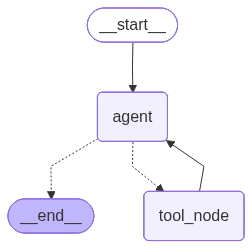

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        search_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage
import json

response = search_app.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})

messages = response['messages']

for msg in messages:
    if isinstance(msg, HumanMessage):
        print(f"\n[Human] {msg.content}")
    elif isinstance(msg, AIMessage):
        print(f"\n[AI] {msg.content}")
        # Check if AIMessage has tool_calls
        if hasattr(msg, "tool_calls") and msg.tool_calls:
            print("  -> AI triggered tools:")
            for tool_call in msg.tool_calls:
                print(f"     Tool name: {tool_call['name']}")
                print(f"     Arguments: {tool_call['args']}")
    elif isinstance(msg, ToolMessage):
        print(f"\n[Tool Output - {msg.name}]")
        try:
            tool_results = json.loads(msg.content)
            for idx, result in enumerate(tool_results):
                print(f"  Result {idx+1}:")
                print(f"    Title: {result.get('title', 'N/A')}")
                print(f"    URL: {result.get('url', 'N/A')}")
                print(f"    Content: {result.get('content', '')[:200]}...")  # truncate
                print(f"    Score: {result.get('score', 'N/A')}")
        except json.JSONDecodeError:
            print("  Could not parse tool message content.")



[Human] How is the weather in Chennai?

[AI] 
  -> AI triggered tools:
     Tool name: tavily_search_results_json
     Arguments: {'query': 'Chennai weather'}

[Tool Output - tavily_search_results_json]
  Result 1:
    Title: Weather in Chennai in October 2025 - Detailed Forecast
    URL: https://www.easeweather.com/asia/india/tamil-nadu/chennai/october
    Content: Until now, October 2025 in Chennai has been nearly identical to the historical average, with a temperature of 31.2 °C (showing only a slight deviation of 0.1 °C).
 Expect cooler weather in the next da...
    Score: 0.93666285
  Result 2:
    Title: Weather Chennai in October 2025: Temperature & Climate
    URL: https://en.climate-data.org/asia/india/tamil-nadu/chennai-1003222/t/october-10/
    Content: | Min. Temperature °C (°F) | 20.8 °C  (69.5) °F | 21 °C  (69.9) °F | 23.1 °C  (73.5) °F | 26.2 °C  (79.1) °F | 28 °C  (82.4) °F | 27.7 °C  (81.9) °F | 27 °C  (80.7) °F | 26.4 °C  (79.5) °F | 26 °C  (7...
    Score: 0.9084964

#Case 1: Shared Schema (Direct Embedding)
You are here make child graph a node and giving it to parent graph

In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with the same schema
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

# Create parent graph
parent_graph = StateGraph(ParentState)

# Add the subgraph as a node
parent_graph.add_node("search_agent", search_app)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"messages": [HumanMessage(content="How is the weather in Chennai?")]})
messages = result['messages']

for msg in messages:
    if isinstance(msg, HumanMessage):
        print(f"\n[Human] {msg.content}")
    elif isinstance(msg, AIMessage):
        print(f"\n[AI] {msg.content}")
        # Check if AIMessage has tool_calls
        if hasattr(msg, "tool_calls") and msg.tool_calls:
            print("  -> AI triggered tools:")
            for tool_call in msg.tool_calls:
                print(f"     Tool name: {tool_call['name']}")
                print(f"     Arguments: {tool_call['args']}")
    elif isinstance(msg, ToolMessage):
        print(f"\n[Tool Output - {msg.name}]")
        try:
            tool_results = json.loads(msg.content)
            for idx, result in enumerate(tool_results):
                print(f"  Result {idx+1}:")
                print(f"    Title: {result.get('title', 'N/A')}")
                print(f"    URL: {result.get('url', 'N/A')}")
                print(f"    Content: {result.get('content', '')[:200]}...")  # truncate
                print(f"    Score: {result.get('score', 'N/A')}")
        except json.JSONDecodeError:
            print("  Could not parse tool message content.")


[Human] How is the weather in Chennai?

[AI] 
  -> AI triggered tools:
     Tool name: tavily_search_results_json
     Arguments: {'query': 'Chennai weather today'}

[Tool Output - tavily_search_results_json]
  Result 1:
    Title: Chennai weather in October 2025 - Weather25.com
    URL: https://www.weather25.com/asia/india/tamil-nadu/chennai?page=month&month=October
    Content: weather25.com
Search
weather in India
Remove from your favorite locations
Add to my locations
Share
weather in India

# Chennai weather in October 2025

Partly cloudy
Light rain shower
Moderate or hea...
    Score: 0.9237645
  Result 2:
    Title: Weather in Chennai in October 2025 - Detailed Forecast
    URL: https://www.easeweather.com/asia/india/tamil-nadu/chennai/october
    Content: easeweather.com
India weather

# Weather in Chennai for October 2025

### Temperatures

Until now, October 2025 in Chennai has been nearly identical to the historical average, with a temperature of 30...
    Score: 0.92359936

# Case 2: Different Schema (Invoke with Transformation)
use this if parent graph has diffrent schema

In [54]:
from typing import TypedDict, Annotated, Dict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

# Define parent graph with different schema
class QueryState(TypedDict):
    query: str
    response: str

# Function to invoke subgraph
def search_agent(state: QueryState) -> Dict:
    # Transform from parent schema to subgraph schema
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }

    # Invoke the subgraph
    subgraph_result = search_app.invoke(subgraph_input)

    # Transform response back to parent schema
    state["response"]= subgraph_result["messages"][-1]
    return state

# Create parent graph
parent_graph = StateGraph(QueryState)

# Add transformation node that invokes subgraph
parent_graph.add_node("search_agent", search_agent)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

# Run the parent graph
result = parent_app.invoke({"query": "How is the weather in Chennai?", "response": ""})
result

{'query': 'How is the weather in Chennai?',
 'response': AIMessage(content='The weather in Chennai is currently warm, with a temperature of 31.2 °C, which is slightly lower than the historical average. However, the forecast suggests that the weather will be cooler in the next few days, with a temperature of 29.2 °C, which is lower than the historical average. The humidity is around 74%, and there have been 3 rainy days so far in October.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1249, 'total_tokens': 1334, 'completion_time': 0.112748409, 'prompt_time': 0.074510861, 'queue_time': 0.053393919, 'total_time': 0.18725927}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--14784203-1c3d-4f10-90d3-d54805835208-0', usage_metadata={'input_tokens': 1249, 'output_tokens': 85, 'total_tokens': 1334})}